<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio



## Set up data

/var/folders/vx/2hn3fq3j01ndcrt24ck57sr80000gn/T/ipykernel_51294/2818794942.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


(512, 512, 3)


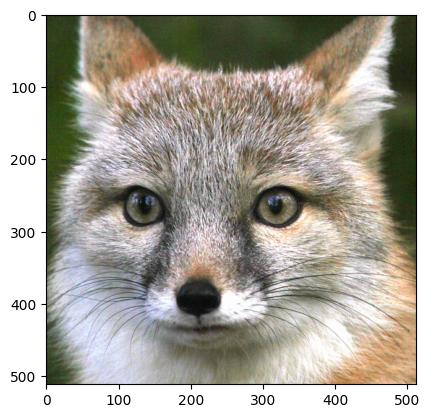

In [2]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

print(img.shape)

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2, ::2], img[::2, ::2]]

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

In [3]:
from function_regression.models import FFNMLP
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

def input_mapping(x, B):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()

    if B is None:
        return x
    else:
        x_proj = ((2. * (np.pi) * x) @ B.T)
        if isinstance(x_proj, np.ndarray):
            x_proj = torch.from_numpy(x_proj)

        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1).float()


def make_network(num_layers, num_channels, in_channels):
    print(in_channels)
    print(num_channels)
    layers = []
    for i in range(num_layers - 1):
        if i == 0:
            layers.append(nn.Linear(in_channels, num_channels))
        else:
            layers.append(nn.Linear(num_channels, num_channels))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(num_channels, 3))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)


def train_model(network_size, learning_rate, iters, scale, train_data, test_data):
    
    config = FFNMLP.default_config()
    config.in_features = 2
    config.out_features = 3
    config.scale = scale
    config.hidden_features = [network_size[1]]*(network_size[0])

    model = FFNMLP(config)  #make_network(*network_size,in_channels)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    print(model)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []

    for i in tqdm(range(iters), desc='train iter', leave=False):
        inputs, targets = train_data

        targets = torch.from_numpy(targets).float()
        inputs = torch.from_numpy(inputs).float()

        #inputs = input_mapping(inputs, B)
        #inputs, targets = Variable(inputs), Variable(targets)
        
        #inputs = inputs.reshape(-1, in_channels).float()
        #targets = targets.reshape(-1, 3).float()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs.reshape(-1, 3), targets.reshape(-1, 3))
        loss.backward()
        optimizer.step()

        B = model.layers[0].B

        if i % 25 == 0:
            train_psnr = compute_psnr(model, train_data, B, criterion)
            test_psnr = compute_psnr(model, test_data, B, criterion)
            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            pred_imgs.append(model(torch.from_numpy(test_data[0]).float()).detach().numpy())
            xs.append(i)

    return {
        'model': model,
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }

def compute_psnr(model, data, B, criterion):
    inputs, targets = data
    
    inputs = torch.from_numpy(inputs).float()
    targets = torch.from_numpy(targets).float()
    #targets = targets.reshape(-1, 3).float()

    outputs = model(Variable(inputs))

    mse_loss = criterion(outputs, Variable(targets)).item() / 2
    psnr = -10 * np.log10(2. * mse_loss)
    return psnr


In [4]:
### What is the loss of a bilinear interpolation model

def bilinear_interpolation_loss(train_data,test_data):
    inputs, targets = train_data
    inputs = torch.from_numpy(inputs).float()
    targets = torch.from_numpy(targets).float().unsqueeze(0).permute(0,3,1,2)

    outputs = torch.nn.functional.interpolate(targets, scale_factor= 2, mode='bicubic').squeeze(0).permute(1,2,0)

    test_input, test_target = test_data

    test_input = torch.from_numpy(test_input).float()
    test_target = torch.from_numpy(test_target).float()

    mse_loss = torch.nn.functional.mse_loss(outputs, test_target).item()
    psnr = -10 * np.log10(2. * mse_loss)
    return psnr


bilinear_interpolation_loss(train_data,test_data)

21.340535609085336

## Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

<!-- - Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$.  -->

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$


In [5]:
network_size = (4, 32)
learning_rate = 1e-4
iters = 2000

mapping_size = 32

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
#B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = np.random.normal(size=(mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = scale#torch.from_numpy(B_gauss * scale).float()

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  print(k)
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

  0%|          | 0/4 [00:00<?, ?it/s]

none
no scale provided
FFNMLP(
  (layers): Sequential(
    (0): FFNLayer()
    (1): Linear(in_features=2, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=3, bias=True)
    (10): Sigmoid()
  )
  (params): ModuleDict(
    (mlp): ModuleList(
      (0): FFNLayer()
      (1): Linear(in_features=2, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=32, bias=True)
      (6): ReLU()
      (7): Linear(in_features=32, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=3, bias=True)
      (10): Sigmoid()
    )
  )
)


train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

gauss_1.0
B: torch.Size([32, 2])
FFNMLP(
  (layers): Sequential(
    (0): FFNLayer()
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=3, bias=True)
    (10): Sigmoid()
  )
  (params): ModuleDict(
    (mlp): ModuleList(
      (0): FFNLayer()
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=32, bias=True)
      (6): ReLU()
      (7): Linear(in_features=32, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=3, bias=True)
      (10): Sigmoid()
    )
  )
)


train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

gauss_10.0
B: torch.Size([32, 2])
FFNMLP(
  (layers): Sequential(
    (0): FFNLayer()
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=3, bias=True)
    (10): Sigmoid()
  )
  (params): ModuleDict(
    (mlp): ModuleList(
      (0): FFNLayer()
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=32, bias=True)
      (6): ReLU()
      (7): Linear(in_features=32, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=3, bias=True)
      (10): Sigmoid()
    )
  )
)


train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

gauss_100.0
B: torch.Size([32, 2])
FFNMLP(
  (layers): Sequential(
    (0): FFNLayer()
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=3, bias=True)
    (10): Sigmoid()
  )
  (params): ModuleDict(
    (mlp): ModuleList(
      (0): FFNLayer()
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=32, bias=True)
      (6): ReLU()
      (7): Linear(in_features=32, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=3, bias=True)
      (10): Sigmoid()
    )
  )
)


train iter:   0%|          | 0/2000 [00:00<?, ?it/s]

## Plot results

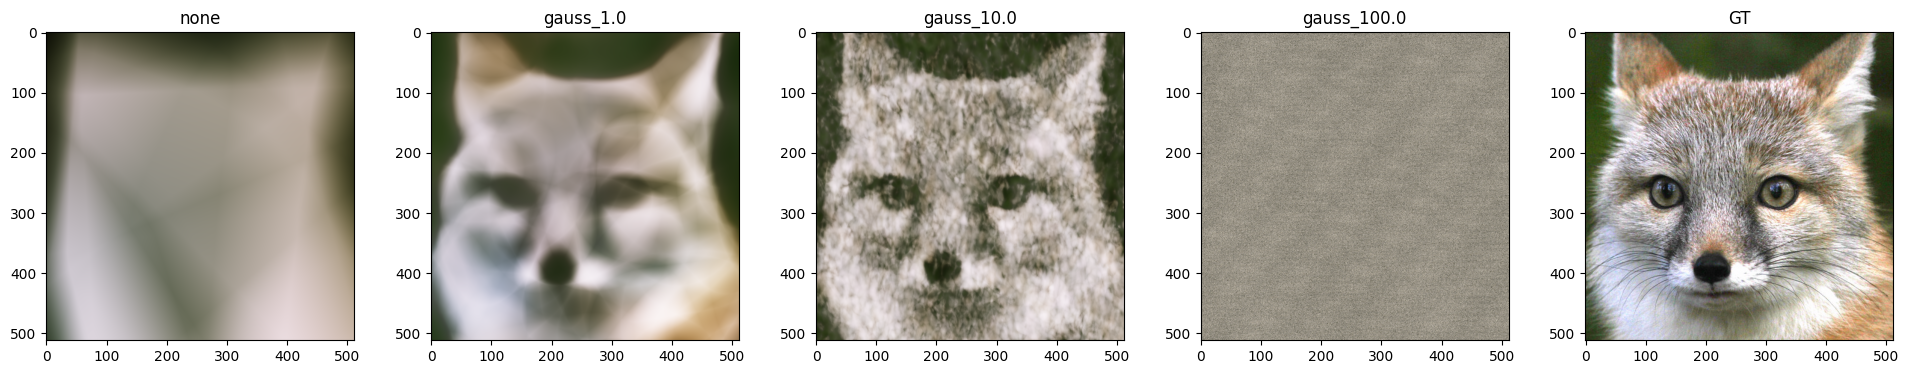

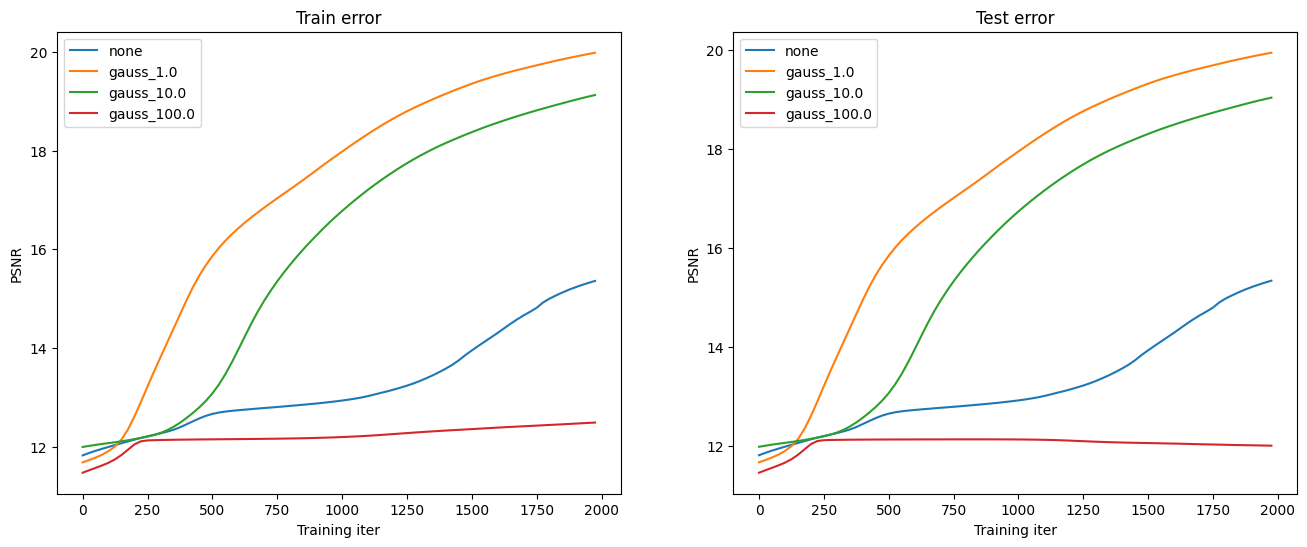

In [6]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [7]:
# Save out video
all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=-2)
data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=1000 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))

RuntimeError: No ffmpeg exe could be found. Install ffmpeg on your system, or set the IMAGEIO_FFMPEG_EXE environment variable.